# 시계열 분석 (Auto ARIMA)

## #01. 작업준비

### 패키지 참조

`pmdarima` 패키지의 설치가 필요하다

In [1]:
from pandas import read_excel, DataFrame, Series
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from pmdarima.arima import auto_arima
from datetime import timedelta
import seaborn as sb
import sys

### 데이터 가져오기

In [2]:
df = read_excel("https://data.hossam.kr/E06/air_passengers.xlsx", index_col="Month")
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


### 그래프 초기화

In [3]:
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["axes.unicode_minus"] = False

## #02. 데이터 분석

### 데이터 분할
처음부터 70% 위치까지의 데이터

분석모델 구축용(=학습용)

In [4]:
# 처음부터 70%위치 전까지 분할
train = df[:int(0.7*len(df))]
train.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


검증용 데이터(나머지 30%)

In [5]:
# 70% 위치부터 끝까지 분할
test = df[int(0.7*len(df)):]
test.head()

,Passengers
Month,
1957-05-01,355
1957-06-01,422
1957-07-01,465
1957-08-01,467
1957-09-01,404


### 모델 구축
시계열데이터를 계절 ARIMA 모델에 맞추려고 할때 첫번째 목표는 측정항목을 최적화하는 $ARIMA(p,d,q)(P,D,Q)M$ 값을 찾는 것

$M$ 값을 고정한 상태에서 0부터 $(p,d,q)(P,D,Q)$로 주어진 값의 범위 안에서 최적의 값을 검색한다

In [6]:
my_p = 5   # 적절히 넉넉히
my_d = 2   # 차분횟수(검증한 결과를 활용)
my_q = 5   # 적절히 넉넉히
my_s = 12  # 계절성 주기(분석가가 판단)

model = auto_arima(
    y=train,            # 모델링하려는 시계열 데이터 또는 배열              
    start_p=0,          # p의 시작점
    max_p=my_p,            # p의 최대값
    d=my_d,                # 차분 횟수
    start_q=0,          # q의 시작점
    max_q=my_q,            # q의 최대값
    seasonal=True,      # 계절성 사용 여부
    m=my_s,                # 계절성 주기
    start_P=0,          # P의 시작점
    max_P=my_p,            # P의 최대값
    D=my_d,                # 계절성 차분 횟수
    start_Q=0,          # Q의 시작점
    max_Q=my_q,            # Q의 최대값
    trace=True          # 학습 과정 표시 여부
)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,2,0)[12]             : AIC=700.560, Time=0.04 sec
 ARIMA(1,2,0)(1,2,0)[12]             : AIC=628.108, Time=0.28 sec
 ARIMA(0,2,1)(0,2,1)[12]             : AIC=inf, Time=0.35 sec
 ARIMA(1,2,0)(0,2,0)[12]             : AIC=656.611, Time=0.04 sec
 ARIMA(1,2,0)(2,2,0)[12]             : AIC=618.256, Time=0.55 sec
 ARIMA(1,2,0)(3,2,0)[12]             : AIC=614.066, Time=1.08 sec
 ARIMA(1,2,0)(4,2,0)[12]             : AIC=609.992, Time=6.90 sec
 ARIMA(1,2,0)(5,2,0)[12]             : AIC=inf, Time=12.98 sec
 ARIMA(1,2,0)(4,2,1)[12]             : AIC=inf, Time=23.73 sec
 ARIMA(1,2,0)(3,2,1)[12]             : AIC=inf, Time=3.57 sec
 ARIMA(1,2,0)(5,2,1)[12]             : AIC=inf, Time=27.19 sec
 ARIMA(0,2,0)(4,2,0)[12]             : AIC=651.167, Time=10.17 sec
 ARIMA(2,2,0)(4,2,0)[12]             : AIC=605.939, Time=11.80 sec
 ARIMA(2,2,0)(3,2,0)[12]             : AIC=606.557, Time=1.32 sec
 ARIMA(2,2,0)(5,2,0)[12]             : AIC=inf, 

### 모델학습

관측치를 모델에 적제하여 학습을 수행한다.

In [7]:
model.fit(train)

ARIMA(order=(5, 2, 1), scoring_args={}, seasonal_order=(3, 2, 0, 12),
      suppress_warnings=True, with_intercept=False)

### 잔차 플롯 검토

왼쪽 상단: 잔차 오차는 평균 0을 중심으로 변동하고 균일한 분산을 갖는 것으로 보임.

오른쪽 상단 : 밀도 도표는 평균이 0인 정규 분포를 나타냄

왼쪽 하단 : 모든 점이 빨간색 선과 완벽하게 일치해야함. 편차가 크면 분포가 왜곡되었음을 의미한다.

오른쪽 하단 : 상관관계도(ACFplot) 는 잔차 오류에 자동 상관되지 않음을 보여줌. 모든 자기상관은 모델에서 설명되지 않는 잔차 오류에 일부 패턴이 있음을 의미하기 때문에 모델에 대해 더 많은 X(예측변수)를 찾아야 함.

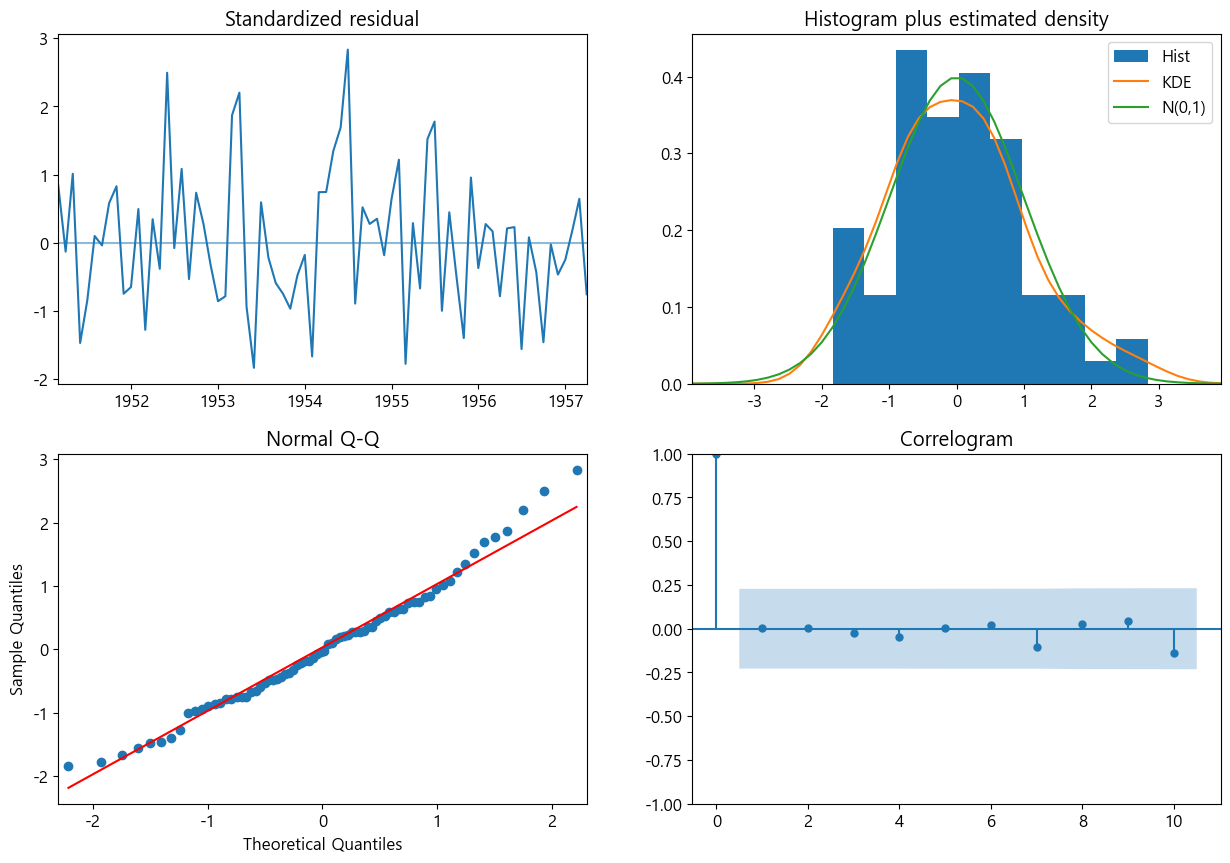

In [8]:
model.plot_diagnostics(figsize=(15,10))
plt.show()

### 예상치 생성

학습결과를 토대로 주어진 `n_periods` 수 만큼의 이후 데이터를 예상하여 결과를 반환한다.

In [9]:
y_predict = model.predict(n_periods=int(len(test)+10))
y_predict

1957-05-01    353.002159
1957-06-01    404.405789
1957-07-01    458.202469
1957-08-01    438.690561
1957-09-01    388.085830
1957-10-01    331.314424
1957-11-01    287.558690
1957-12-01    327.150142
1958-01-01    337.123758
1958-02-01    318.146074
1958-03-01    370.268776
1958-04-01    360.140760
1958-05-01    368.961721
1958-06-01    435.886682
1958-07-01    496.441191
1958-08-01    468.142021
1958-09-01    412.564402
1958-10-01    347.660578
1958-11-01    302.564436
1958-12-01    346.768189
1959-01-01    358.433871
1959-02-01    341.137617
1959-03-01    392.111770
1959-04-01    382.595240
1959-05-01    388.226219
1959-06-01    462.223178
1959-07-01    526.217801
1959-08-01    494.134207
1959-09-01    431.675541
1959-10-01    356.462186
1959-11-01    303.331369
1959-12-01    352.017045
1960-01-01    360.145634
1960-02-01    338.458705
1960-03-01    396.051603
1960-04-01    380.213371
1960-05-01    387.912074
1960-06-01    467.504490
1960-07-01    532.165566
1960-08-01    497.112771


### 관측치와 예상치 비교

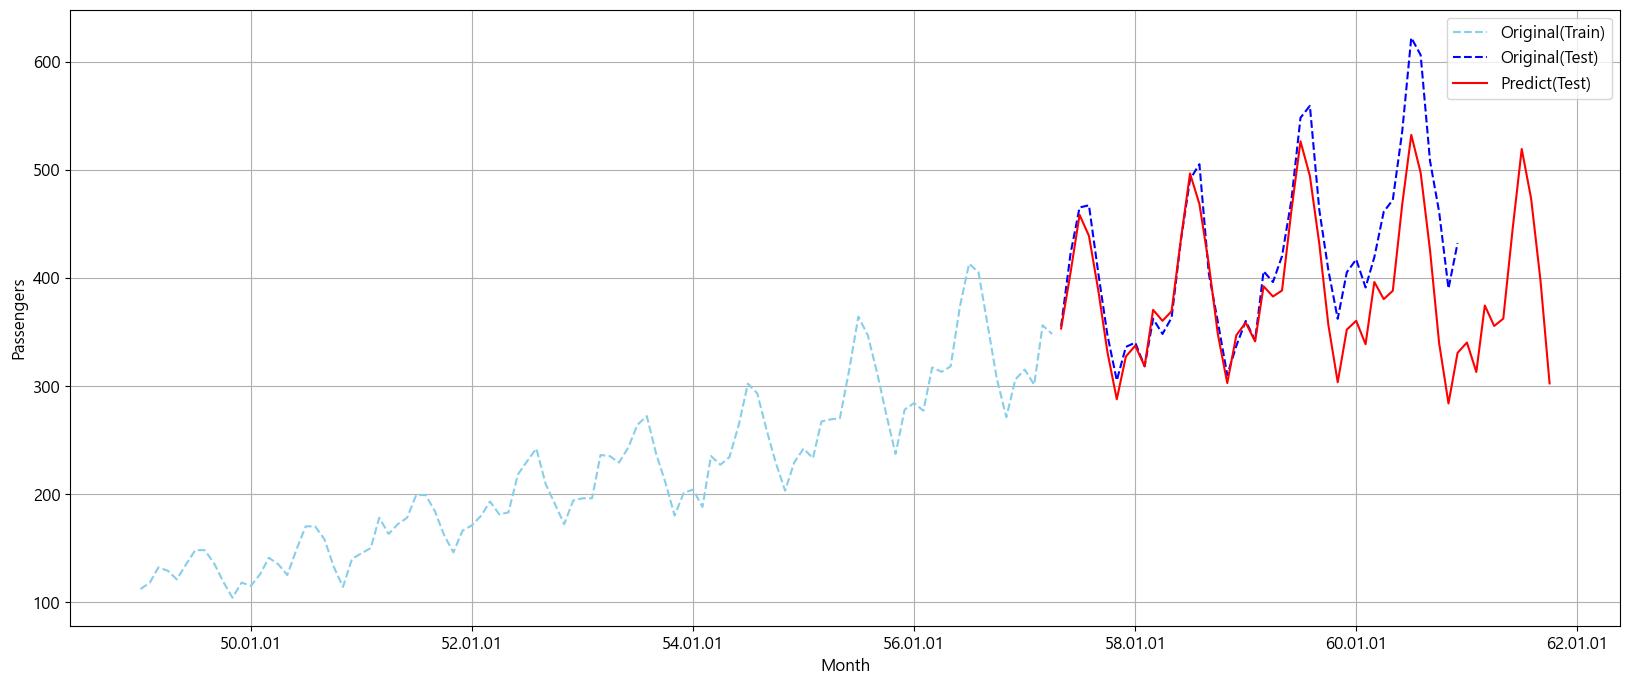

In [10]:
plt.figure(figsize=(20,8))

# 앞 70%의 원본 데이터
sb.lineplot(data=train, x=train.index, y='Passengers', label='Original(Train)', linestyle='--', color='skyblue')

# 뒤 30%의 원본 데이터
sb.lineplot(data=test, x=test.index, y='Passengers', label='Original(Test)', linestyle='--', color='blue')

# 뒤 30% + 10단계에 대한 예측 데이터
sb.lineplot(x=y_predict.index, y=y_predict.values, label='Predict(Test)', color='red')

plt.xlabel('Month')
plt.ylabel('Passengers')

# 그래프의 x축이 날짜로 구성되어 있을 경우 형식 지정
monthyearFmt = mdates.DateFormatter('%y.%m.%d')
plt.gca().xaxis.set_major_formatter(monthyearFmt)

plt.grid()
plt.show()
plt.close()